In [10]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

import matplotlib.pyplot as plt

In [2]:
# dataset
df = pd.read_csv('ethereum_price_model.csv')
df.head()

,Unnamed: 0,Date,Price,Open,High,Low,Vol.,Change %
0,0,2023-03-08,1553.49,1561.79,1569.70,1548.98,498570,-0.53
1,1,2023-03-07,1561.78,1565.84,1580.95,1536.31,460100,-0.26
2,2,2023-03-06,1565.84,1564.36,1581.13,1555.43,322160,0.09
3,3,2023-03-05,1564.37,1566.73,1587.95,1556.84,313010,-0.15
4,4,2023-03-04,1566.73,1569.45,1577.02,1550.10,247020,-0.14


In [3]:
# separate df to training and testing set

# training set
df_train = df.iloc[:2542, 2:3].values

# testing set
df_test = df.iloc[2542:, 2:3].values

In [4]:
# scaling
sc = MinMaxScaler(feature_range = (0, 1))
df_scaled = sc.fit_transform(df_train)

In [5]:
# creating data with timesteps
X_train = []
y_train = []
for i in range(60, 2542):
    X_train.append(df_scaled[i-60:i, 0])
    y_train.append(df_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [6]:
# building the LSTM
regressor = Sequential()

regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
78/78 [==============================] - 13s 68ms/step - loss: 0.0072
Epoch 2/100
78/78 [==============================] - 5s 68ms/step - loss: 0.0032
Epoch 3/100
78/78 [==============================] - 5s 66ms/step - loss: 0.0029
Epoch 4/100
78/78 [==============================] - 5s 66ms/step - loss: 0.0025
Epoch 5/100
78/78 [==============================] - 5s 61ms/step - loss: 0.0024
Epoch 6/100
78/78 [==============================] - 5s 60ms/step - loss: 0.0022
Epoch 7/100
78/78 [==============================] - 5s 61ms/step - loss: 0.0020
Epoch 8/100
78/78 [==============================] - 5s 67ms/step - loss: 0.0020
Epoch 9/100
78/78 [==============================] - 5s 67ms/step - loss: 0.0021
Epoch 10/100
78/78 [==============================] - 5s 65ms/step - loss: 0.0016
Epoch 11/100
78/78 [==============================] - 6s 72ms/step - loss: 0.0016
Epoch 12/100
78/78 [==============================] - 6s 72ms/step - loss: 0.0015
Epoch 13/100
78/78 [====

In [7]:
# predictions, reformatting to readable format

df_pred = df['Price']
inputs = df_pred[len(df) - len(df_test) - 60:].values
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)

X_test = []
for i in range(60, 76):
    X_test.append(inputs[i - 60:i, 0])

X_test = [x.tolist() for x in X_test]
length = max(map(len, X_train))
X_test = np.array([x + [0] * (length - len(x)) for x in X_test])

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))



predicted_eth_price = regressor.predict(X_test)
predicted_eth_price = sc.inverse_transform(predicted_eth_price)

1/1 [==============================] - 1s 1s/step


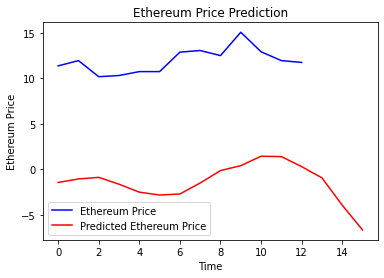

In [11]:
# results
plt.plot(df_test, color = 'blue', label = 'Ethereum Price')
plt.plot(predicted_eth_price, color = 'red', label = 'Predicted Ethereum Price')
plt.title('Ethereum Price Prediction')
plt.xlabel('Time')
plt.ylabel('Ethereum Price')
plt.legend()
plt.show()